## 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [34]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu126'

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
device

device(type='cuda', index=0)

## 6.1 Data

In [37]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Split the data

In [38]:
# Create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [39]:
# Define the plot_predictions() function
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))

    # Plot training data
    plt.scatter(train_data, train_labels, label='Train Data', color='blue')

    # Plot test data
    plt.scatter(test_data, test_labels, label='Test Data', color='green')

    # Check if predictions is not None
    if predictions is not None:
        plt.scatter(test_data, predictions, label='Predictions', color='red')

    # Show legend
    plt.legend(prop={'size': 14})
    plt.show()

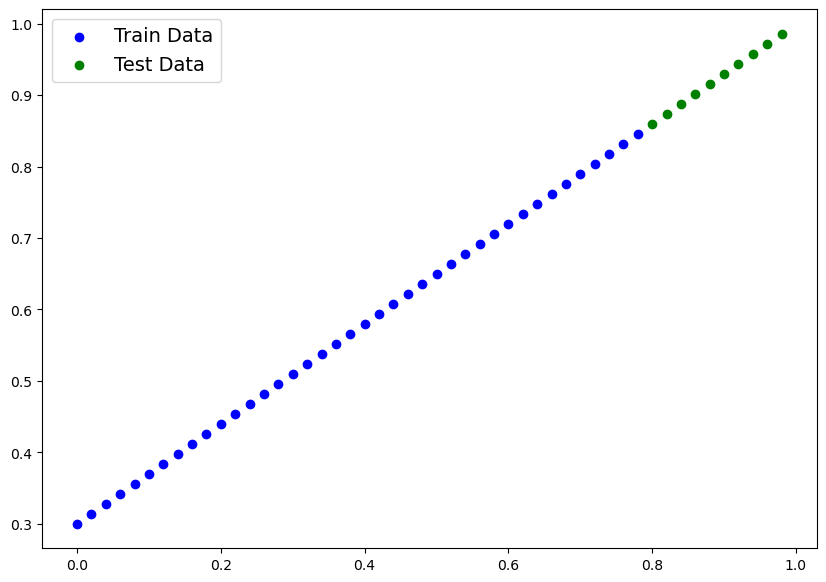

In [40]:
# Plot the data

plot_predictions(X_train,y_train,X_test,y_test)

## 6.2 Building a PyTorch Linear Model

In [41]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters / also called linear transform, probing layer, fully connected later, dense layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [42]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

### Choose Device

In [43]:
next(model_1.parameters()).device

device(type='cpu')

In [44]:
# Set the model to use the target device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [45]:
# Setup loss function
loss_fn = nn.L1Loss()

# Set up the optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)


In [46]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device-agnostic code)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. Forward oass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch 0, Train Loss: 0.5552, Test Loss: 0.5740
Epoch 10, Train Loss: 0.4400, Test Loss: 0.4393
Epoch 20, Train Loss: 0.3248, Test Loss: 0.3046
Epoch 30, Train Loss: 0.2095, Test Loss: 0.1698
Epoch 40, Train Loss: 0.0943, Test Loss: 0.0351
Epoch 50, Train Loss: 0.0239, Test Loss: 0.0478
Epoch 60, Train Loss: 0.0200, Test Loss: 0.0458
Epoch 70, Train Loss: 0.0165, Test Loss: 0.0375
Epoch 80, Train Loss: 0.0131, Test Loss: 0.0299
Epoch 90, Train Loss: 0.0097, Test Loss: 0.0217
Epoch 100, Train Loss: 0.0062, Test Loss: 0.0141
Epoch 110, Train Loss: 0.0028, Test Loss: 0.0058
Epoch 120, Train Loss: 0.0013, Test Loss: 0.0138
Epoch 130, Train Loss: 0.0013, Test Loss: 0.0138
Epoch 140, Train Loss: 0.0013, Test Loss: 0.0138
Epoch 150, Train Loss: 0.0013, Test Loss: 0.0138
Epoch 160, Train Loss: 0.0013, Test Loss: 0.0138
Epoch 170, Train Loss: 0.0013, Test Loss: 0.0138
Epoch 180, Train Loss: 0.0013, Test Loss: 0.0138
Epoch 190, Train Loss: 0.0013, Test Loss: 0.0138


In [47]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

## 6.4 Making and evaluating predictions

In [48]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

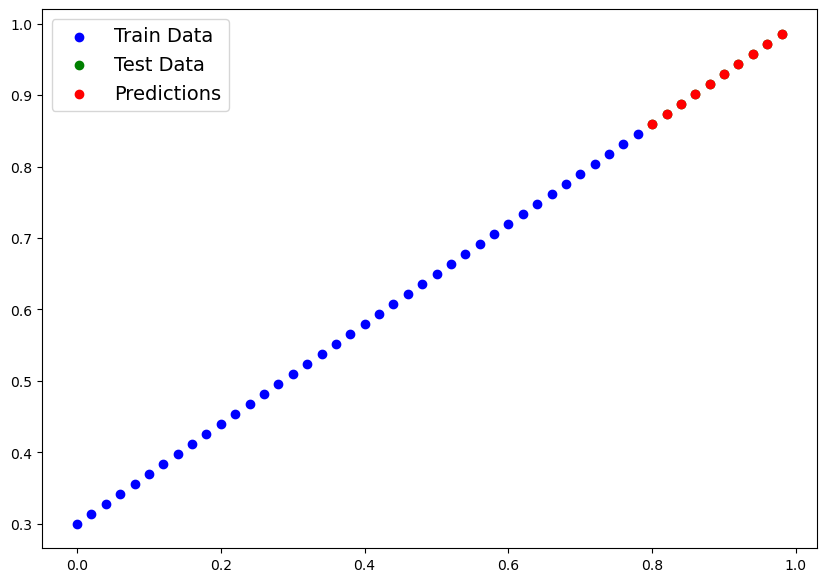

In [49]:
# Check out our model predictions visually
plot_predictions(predictions = y_preds.cpu())

## 6.5 Saving and loading a trained model

In [50]:
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True, parents=True)

# 2. Create model save path
MODEL_NAME = "01_wf2_linear_model_v2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to models\01_wf2_linear_model_v2.pth


In [51]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [52]:
# Load a PyTorch model

# Create a new instance of Linear Regression model V2
loaded_model_1= LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [53]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [54]:
loaded_model_1.eval().state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [55]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
    y_preds == loaded_model_1_preds

In [56]:
loaded_model_1_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')